In [23]:
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add the parent directory to sys.path for module searching
sys.path.append(parent_dir)

import pandas as pd
from Pilsung import*
from Model.CNN import cnn_classifier
from utils.LoadData import load_CW_Source,load_CW_Target
from sklearn.utils import shuffle

In [24]:
def calculate_confidential_accuracy(profiling_Data_path, Target_Data_path, model_path, model_name, 
                                   p_attack_to_label_total, confidence_threshold=0.5):
    """Calculate confidential prediction accuracy with reliability threshold
    
    Args:
        profiling_Data_path (str): Path to profiling traces dataset
        Target_Data_path (str): Path to attack traces dataset  
        model_path (str): Directory containing pre-trained model
        model_name (str): Filename of the pre-trained model
        p_attack_to_label_total (list): Ground truth label mapping
        confidence_threshold (float): Minimum confidence score for reliable predictions (default: 0.5)
        
    Returns:
        tuple: (accuracy_list, reliable_num_list) 
               - accuracy_list: Average accuracy values for each trace count
               - reliable_num_list: Average number of reliable predictions
    """
    # Initialize data containers
    pk_v_box = np.zeros((256, 256))  # Key-byte probability matrix
    p_v_box = np.zeros(256)          # Plaintext-to-label mappings
    p_v_prob = np.zeros(256)         # Confidence scores storage
    acc = []                         # Accuracy results
    reliable_num_avg = []            # Reliable predictions count

    # Main experiment loop 
    for trace_num in range(1000, 8001, 1000):
        run_acc = []          # Temporary accuracy storage
        total_reliable = 0    # Reliable predictions counter
        
        # Repeat experiment 20 times
        for _ in range(15):
            # Data loading (preserve original structure)
            profiling_traces, _, _, _, _, _ = load_CW_Source(
                in_file=profiling_Data_path,
                sec=18000
            )
            X_attack, label_V, p_attack = load_CW_Target(
                in_file=Target_Data_path,
            )
            
            # Data preprocessing pipeline
            X_attack, label_V, p_attack = shuffle(X_attack, label_V, p_attack)
            X_attack_shuffle = X_attack[:trace_num]
            p_attack_shuffle = p_attack[:trace_num]

            # Feature scaling
            scaler = preprocessing.StandardScaler()
            profiling_traces = scaler.fit_transform(profiling_traces)
            X_attack_shuffle = scaler.transform(X_attack_shuffle)
            
            scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
            profiling_traces = scaler.fit_transform(profiling_traces)
            X_attack_shuffle = scaler.transform(X_attack_shuffle)

            # Model prediction
            model = cnn_classifier(input_size=600)
            model.load_weights(model_path + model_name)
            predictions = model.predict(X_attack_shuffle)

            # Process predictions
            # df = pd.DataFrame({
            #     'traces': np.squeeze(predictions),
            #     'plaintext': np.squeeze(p_attack_shuffle)
            # })
            A = np.squeeze(predictions)  # Predictions
            B = np.squeeze(p_attack_shuffle)     # Plaintext
            df = pd.DataFrame({'traces': list(A), 'plaintext': list(B)})
            sum_by_plaintext = df.groupby('plaintext')['traces'].mean()

            # Update confidence matrix
            for j in range(256):
                if j in sum_by_plaintext:
                    p_v_box[j] = np.argmax(sum_by_plaintext[j])
                    p_v_prob[j] = np.max(sum_by_plaintext[j])
                else:
                    p_v_box[j] = -1
                    p_v_prob[j] = -1

            # Filter reliable predictions using threshold
            reliable_predictions = [p for p in range(256) if p_v_prob[p] >= confidence_threshold]
            total_reliable += len(reliable_predictions)

            # Calculate thresholded accuracy
            total_num = acc_num = 0.0
            for p in reliable_predictions:
                if p_v_box[p] == -1:
                    continue
                if p_v_box[p] == p_attack_to_label_total[0][p]:
                    acc_num += 1
                total_num += 1
                
            run_acc.append(acc_num / total_num if total_num > 0 else 0.0)

        # Store averaged results
        acc.append(np.mean(run_acc))
        reliable_num_avg.append(total_reliable / 15)
        print(f"Traces: {trace_num} | Accuracy: {acc[-1]:.4f} | The num of reliable classes : {reliable_num_avg[-1]:.1f}")

    return acc, reliable_num_avg

<b>From the attack dataset, obtain all the mapping  $ \phi: p \mapsto v$.


In [25]:
# Main parameter initialization
profiling_Data_path='./Dataset/rk1=0x35/'
Target_Data_path = './Dataset/rk1=0xce/'  # Path to target device traces
model_path = './Model/'  # Pre-trained model directory
model_name = 'Source_Model(RK1=0x35).h5'  # Model filename

In [26]:
X_attack, label_V, p_attack = load_CW_Target(
            in_file=Target_Data_path)
p_attack_to_label_total=[]
p_attack_to_label_total.append({p: np.unique(label_V[p_attack == p]) for p in range(256)})

In [27]:
acc_rk1_0xce_total=[]
reliable_num_avg_total=[]
for threshold in [0.5,0.6,0.7,0.8,0.9]:
        print(f'"######threshold: {threshold}######')
        acc_rk1_0xce,reliable_num_avg=calculate_confidential_accuracy(profiling_Data_path, Target_Data_path, model_path, model_name, 
        p_attack_to_label_total, confidence_threshold=threshold)
        acc_rk1_0xce_total.append(acc_rk1_0xce)
        reliable_num_avg_total.append(reliable_num_avg)


"######threshold: 0.5######
Traces: 1000 | Accuracy: 0.9298 | The num of reliable classes : 212.1
Traces: 2000 | Accuracy: 0.9627 | The num of reliable classes : 215.5
Traces: 3000 | Accuracy: 0.9726 | The num of reliable classes : 215.9
Traces: 4000 | Accuracy: 0.9735 | The num of reliable classes : 217.0
Traces: 5000 | Accuracy: 0.9771 | The num of reliable classes : 218.4
Traces: 6000 | Accuracy: 0.9791 | The num of reliable classes : 217.1
Traces: 7000 | Accuracy: 0.9801 | The num of reliable classes : 217.8
Traces: 8000 | Accuracy: 0.9844 | The num of reliable classes : 217.9
"######threshold: 0.6######
Traces: 1000 | Accuracy: 0.9455 | The num of reliable classes : 186.5
Traces: 2000 | Accuracy: 0.9790 | The num of reliable classes : 189.9
Traces: 3000 | Accuracy: 0.9835 | The num of reliable classes : 188.9
Traces: 4000 | Accuracy: 0.9902 | The num of reliable classes : 190.6
Traces: 5000 | Accuracy: 0.9905 | The num of reliable classes : 189.8
Traces: 6000 | Accuracy: 0.9915 | 

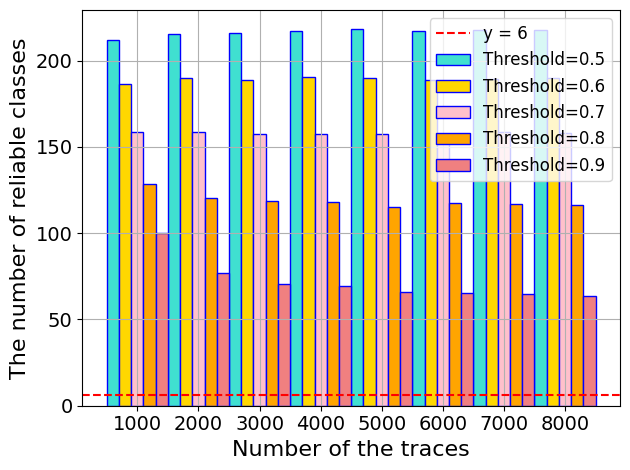

In [28]:
x = np.arange(1000, 8001, 1000)

bar_width = 200  # 设置柱状图宽度
offset = bar_width * 1  # 确保柱之间有适当间隔

# 调整每组柱的中心位置
x1 = x - 2 * offset
x2 = x - offset
x3 = x
x4 = x + offset
x5 = x + 2 * offset

plt.bar(x1, reliable_num_avg_total[0][:], width=bar_width, color='turquoise', edgecolor='blue',label='Threshold=0.5')
plt.bar(x2, reliable_num_avg_total[1][:], width=bar_width, color='gold', edgecolor='blue',label='Threshold=0.6')
plt.bar(x3, reliable_num_avg_total[2][:], width=bar_width, color='pink', edgecolor='blue',label='Threshold=0.7')
plt.bar(x4, reliable_num_avg_total[3][:], width=bar_width, color='orange', edgecolor='blue',label='Threshold=0.8')
plt.bar(x5, reliable_num_avg_total[4][:], width=bar_width, color='lightcoral', edgecolor='blue',label='Threshold=0.9')

plt.grid(True)  # 添加网格
# 添加 y=5 的横线
plt.axhline(y=6, color='red', linestyle='--', label='y = 6')

plt.xlabel('Number of the traces', fontsize=16)
plt.ylabel('The number of reliable classes', fontsize=16)
plt.legend(fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('reliable classes.pdf')
plt.show()

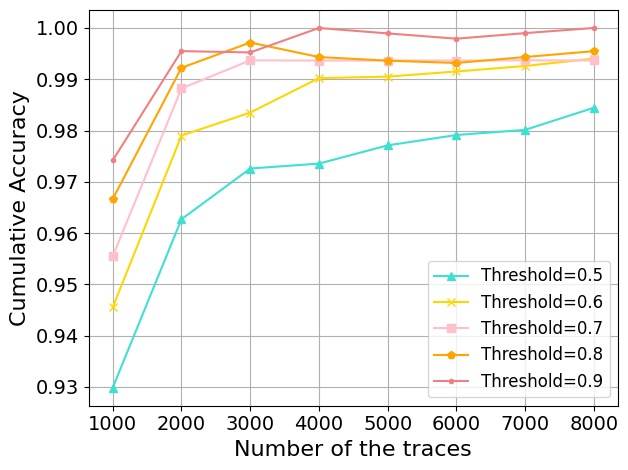

In [29]:
x = np.arange(1000, 8001, 1000)
plt.plot(x, acc_rk1_0xce_total[0][:],color='turquoise', marker='^',label='Threshold=0.5')
plt.plot(x, acc_rk1_0xce_total[1][:],color='gold',marker='x',label='Threshold=0.6')
plt.plot(x, acc_rk1_0xce_total[2][:],color='pink',marker='s',label='Threshold=0.7')
plt.plot(x, acc_rk1_0xce_total[3][:],color='orange',marker='p',label='Threshold=0.8')
plt.plot(x, acc_rk1_0xce_total[4][:],color='lightcoral',marker='.',label='Threshold=0.9')

plt.grid(True)  # 添加网格
# plt.scatter(x, SM4_avg[1:], color='red', marker='^')  # 标记点
# plt.scatter(x, SK_avg[1:], color='red', marker='x')  # 标记点
plt.xlabel('Number of the traces', fontsize=16)
plt.ylabel('Cumulative Accuracy', fontsize=16)
plt.legend(fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('Pilsung_CA.pdf')

plt.show()